# Проект: 'Отток клиентов'

**Предыстория:** Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
## Цель проекта: 
- 1)Спрогнозировать, уйдёт клиент из банка в ближайшее время или нет 
- 2) Построить модель с предельно большим значением (не менее 0.59) F1-меры 

### Описание данных
**Признаки:**
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

**Целевой признак:**
- `Exited` — факт ухода клиента

In [1]:
# импортируем нужные для работы библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, f1_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV
pd.options.mode.chained_assignment = None

## Подготовка данных

In [2]:
#загрузим данные
server = '/datasets/Churn.csv'                
local = 'Churn.csv'
try:
    df = pd.read_csv(server)
except: 
    df = pd.read_csv(local)

In [3]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


-  В распоряжении имеем 10 тыс. объектов и 13 признаков для каждого 14-1(RowNumber - дублер индекса таблицы)

### 1.1 Предобработка данных

- На первый взгляд предобработки требуют следующие пункты:
1. RowNumber - дублер индекса таблицы
2. Приведем названия столбцов к нижнему регистру и snake_case

In [5]:
#изучим столбцы
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
#удалим столбец RowNumber
df = df.drop(labels ='RowNumber',axis = 1).reset_index(drop=True)

In [7]:
#проверим
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [8]:
#обработает столбцы с помощью атрибута columns
df.columns = ['customer_id', 'surname','credit_score','geography','gender','age','tenure',
              'balance','num_of_products','has_cr_card','is_active_member','estimated_salary','exited']

In [9]:
#проверим
df.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [10]:
#посчитаем пропущенные значения
df.isna().sum()

customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

- В столбце tenure(сколько лет человек является клиентом банка) 9% процентов пропущенных значений

In [11]:
df['tenure'].mean(), df['tenure'].median()

(4.997690023099769, 5.0)

In [12]:
#заменим пропущенное значение на среднее
df['tenure'] = df['tenure'].fillna(df['tenure'].mean())

In [13]:
#проверим
df.isna().sum()

customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [14]:
#посмотрим описательную статистику
df.describe()

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,1.000000e+04,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,4.99769,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,4.99769,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [15]:
#так же предлагаю столбец customer_id удалить так как этот признак не несет смысла для модели
df.drop(labels ='customer_id',axis = 1,inplace=True)

In [16]:
#проверим
df.head()

,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [17]:
#посчитаем дубликаты
df.duplicated().sum()

0

In [18]:
#посмотрим 10 случайных фамилий
df['surname'].sample(n=10,random_state=1)

9953             Burke
3850        Stephenson
4962            Gordon
3886              Tien
5437          Gonzalez
8517          Robinson
2041               Yeh
1989           Zaitsev
1933             Bogle
9984    Echezonachukwu
Name: surname, dtype: object

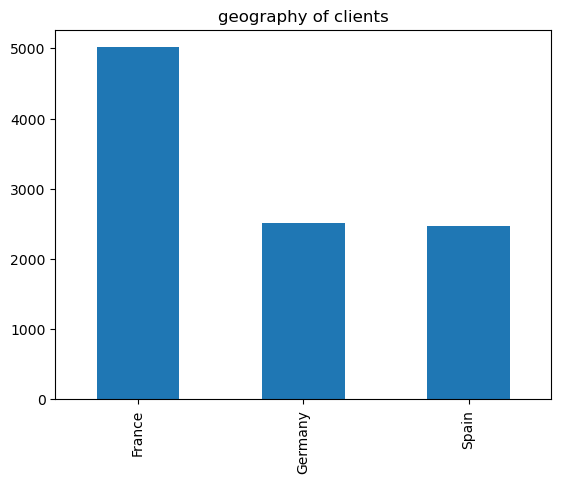

In [19]:
#посмотрим место проживания
df['geography'].value_counts().plot(kind='bar')
plt.title('geography of clients')
plt.show()

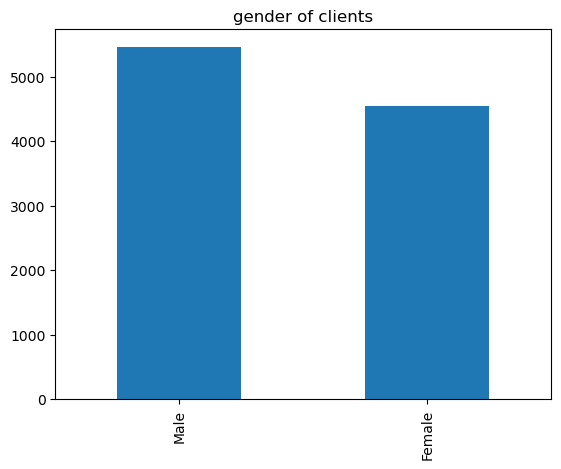

In [20]:
#посмотрим пол
df['gender'].value_counts().plot(kind='bar')
plt.title('gender of clients')
plt.show()

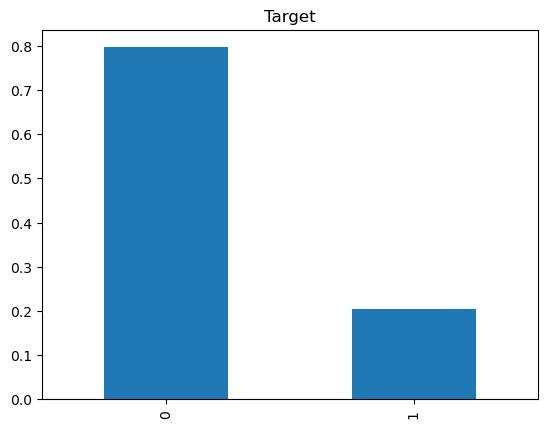

In [21]:
#посмотрим целевой признак
df['exited'].value_counts(normalize=True).plot(kind='bar')
plt.title('Target')
plt.show()

**Вывод:**
- Мы познакомились с таблицей, удалили дублер индекса, поправили названия колонок, так же узнали что в нашей таблицы больше мужчин чем женщин,  по кол-ву клиентов Франция на первом месте
- Так же узнали что у целевого признака присутствует дисбаланс классов отрицательных больше чем положительных

## Исследование задачи
**Цель:** Изучить модели без учёта дисбаланса 

In [22]:
#удалим столбец surname так как этот признак не несет смысла для модели
df.drop(labels ='surname',axis = 1,inplace=True)

In [23]:
#с помощью техники прямого кодирования преобразуем все категориальные значения в численные
#drop_first удаляет первую колонку, которая создается для первого уникального значения столбца
data = pd.get_dummies(df, drop_first=True)

In [24]:
#создадим отдельно все признаки и отдельно целевой
features = data.drop(labels='exited',axis=1)
#целевой признак
target = df['exited']

In [25]:
#проверим
features.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0


In [26]:
#проверим
target.head()

0    1
1    0
2    1
3    0
4    0
Name: exited, dtype: int64

In [27]:
#разделим выборку на обучающую и тестовую 70:30
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.3, random_state=1)

In [28]:
print('Размер обучающей: ',X_train.shape,y_train.shape)
print('Размер тестовой: ',X_test.shape,y_test.shape)

Размер обучающей:  (7000, 11) (7000,)
Размер тестовой:  (3000, 11) (3000,)


### RandomForestClassifier

In [29]:
#посмотри какие признаки важны для модели
model = RandomForestClassifier(random_state=1, max_depth=6,n_estimators=20)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=20, random_state=1)

<AxesSubplot:xlabel='gini_coef'>

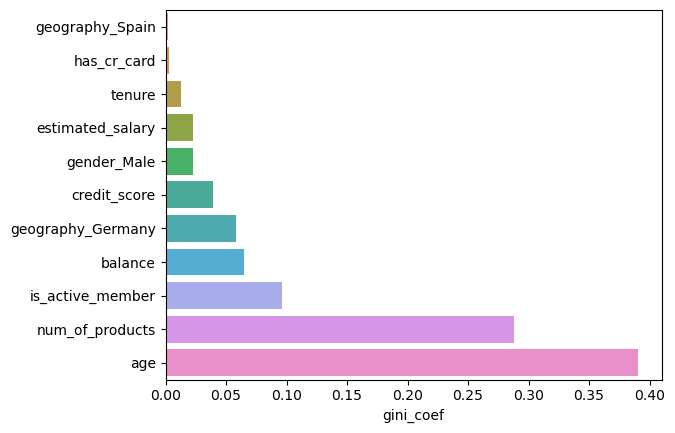

In [30]:
#посмотрим важность признаков
feats = {}
for feature,importace in zip(features,model.feature_importances_):
    feats[feature] = importace
    data = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'gini_coef'}).sort_values(by='gini_coef')
#построим диаграмму
sns.barplot(data=data,x='gini_coef',y=data.index)

In [31]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

- Топ 3 важных признака по мнению модели это:
1. Возраст
2. Количество продуктов банка, используемых клиентом
3. Активность клиента
- Так же интересно, что для модели важно клиент из Германии

In [32]:
#сделаем предсказание и посчитаем f1
pred = model.predict(X_test)
f1 = f1_score(y_test, pred)

In [33]:
print('F1: ',f1)

F1:  0.5011037527593819


In [34]:
#считаем вероятности классов
prob_val = model.predict_proba(X_test)

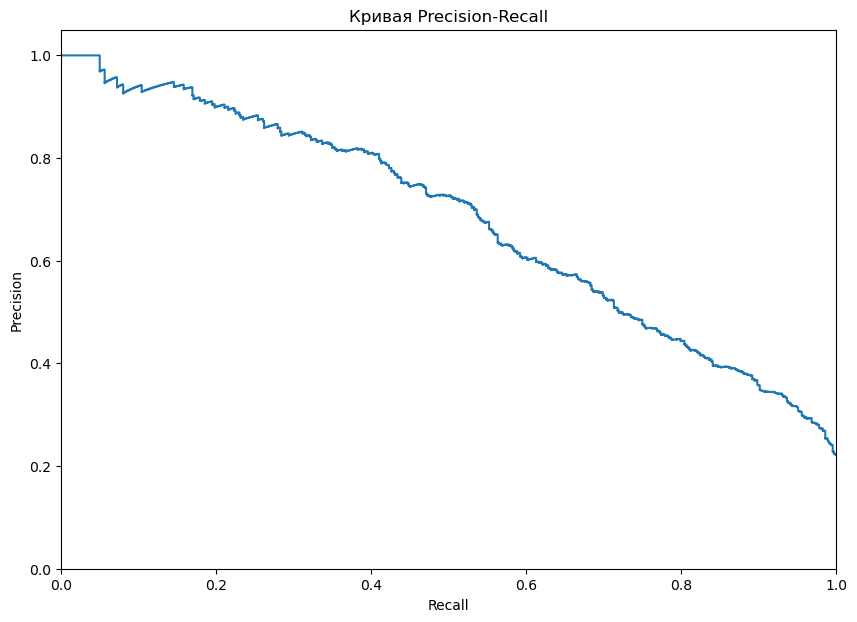

In [35]:
#посмотрим на точность и полноту на графике
precision, recall, thresholds = precision_recall_curve(y_test, prob_val[:, 1])

plt.figure(figsize=(10, 7))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

- Смотрим зависимость точности от полноты, чем выше точность, тем ниже полнота, чем больше полнота тем ниже точность

In [36]:
#thresholds

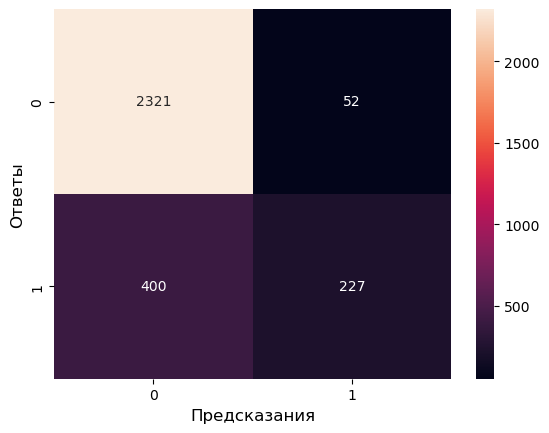

In [37]:
#посмотрим матрицу ошибок 
cf_m = confusion_matrix(y_test, pred)
sns.heatmap(cf_m,annot=True, fmt = 'd')
plt.xlabel('Предсказания', fontsize = 12)
plt.ylabel('Ответы', fontsize = 12)
plt.show()

- Наша модель предсказывает больше отрицательный класс, неудивительно, ведь классы несбалансированы

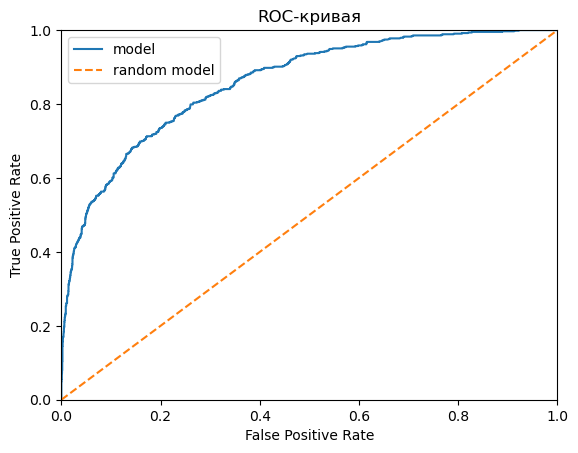

In [38]:
#построим график roc
fpr, tpr, thresholds = roc_curve(y_test, prob_val[:, 1])

plt.figure()
plt.plot(fpr, tpr, label='model')
plt.legend()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--', label='random model')
plt.legend()

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

In [39]:
# посчитаем площадь под кривой
auc_roc = roc_auc_score(y_test, prob_val[:, 1])
print('AUC-ROC: ', auc_roc)

AUC-ROC:  0.8583677617212784


- Положительный класс существенно меньше по размеру, то AUC-ROC может давать не совсем адекватную оценку качества работы алгоритма, поскольку измеряет долю неверно принятых объектов относительно общего числа отрицательных.

## Борьба с дисбалансом

### Upsampling - увеличим кол-во положительных объектов

In [40]:
#посмотрим классы целевого признака
y_train.value_counts()

0    5590
1    1410
Name: exited, dtype: int64

In [41]:
#функция, вернет увеличенный положительный класс
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    X_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    y_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=1)
    
    return X_upsampled, y_upsampled

In [42]:
#увеличим положительный класс в 4 раза
X_upsampled, y_upsampled = upsample(X_train, y_train, 4)

In [43]:
X_upsampled.shape,  y_upsampled.shape

((11230, 11), (11230,))

In [44]:
#проверим
y_upsampled.value_counts()

1    5640
0    5590
Name: exited, dtype: int64

### GridSearchCV - upsampling

In [45]:
#создадим модель
rfc = RandomForestClassifier(random_state=1)
#создаём словарь в котором будут содержаться условия которые будут тестироваться с помощью GridSearch
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1, 12), #7
              'min_samples_leaf': range (1,5),
              'min_samples_split': range (2,10,2)}

In [46]:
%%time
#поиск лучших гиперпараметров для модели
grid = GridSearchCV(rfc, parametrs, cv=5,verbose = 5, n_jobs=-1)
grid.fit(X_upsampled, y_upsampled)

Fitting 5 folds for each of 880 candidates, totalling 4400 fits
Wall time: 12min 47s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': range(1, 12),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)},
             verbose=5)

In [47]:
#посмотрим какие параметры подобрал этот механизм
grid.best_params_

{'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 40}

In [48]:
#сделаем предсказание и посчитаем f1
rfc = grid.best_estimator_
pred = rfc.predict(X_test)
f1 = f1_score(y_test, pred)
print('F1: ',f1)

F1:  0.6264150943396226


- **Лучшая модель по [итогам исследования](#finish)**
<a id='start'></a>

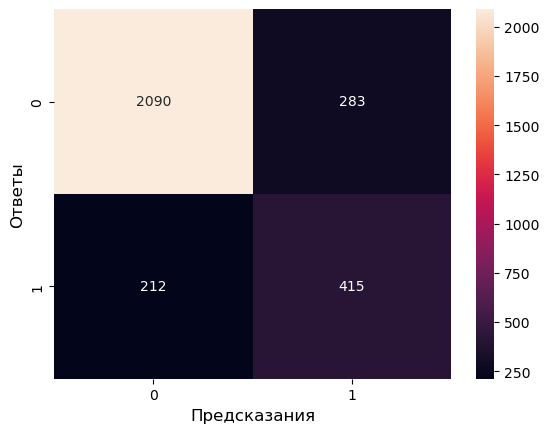

In [49]:
#посмотрим матрицу ошибок 
cf_m = confusion_matrix(y_test, pred)
sns.heatmap(cf_m,annot=True, fmt = 'd')
plt.xlabel('Предсказания', fontsize = 12)
plt.ylabel('Ответы', fontsize = 12)
plt.show()

- Можно сказать, что после upsampling'a произошли небольшие улучшения, модель стала видеть больше положительный класс, но так же выросло кол-во ложно положительных

In [50]:
#считаем вероятности классов
prob_val = rfc.predict_proba(X_test)

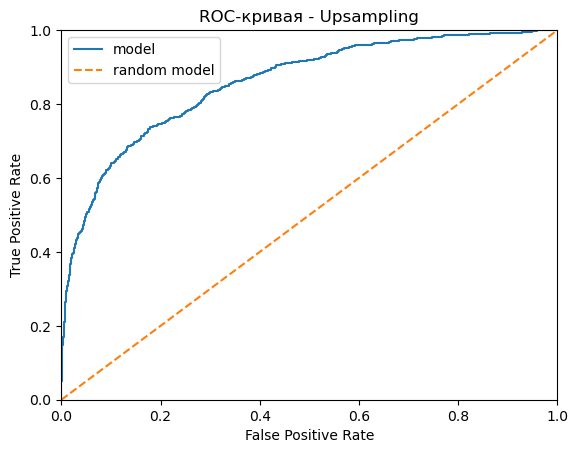

In [51]:
#построим график roc
fpr, tpr, thresholds = roc_curve(y_test, prob_val[:, 1])

plt.figure()
plt.plot(fpr, tpr, label='model')
plt.legend()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--', label='random model')
plt.legend()

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая - Upsampling')
plt.show()

In [52]:
# посчитаем площадь под кривой
auc_roc = roc_auc_score(y_test, prob_val[:, 1])
print('AUC-ROC: ', auc_roc)

AUC-ROC:  0.8584621919507806


**Downsampling - уменьшение выборки**

In [53]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    X_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=1)] + [features_ones])
    y_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=1)] + [target_ones])
    
    X_downsampled, y_downsampled = shuffle(X_downsampled, y_downsampled, random_state=1)
    
    return X_downsampled, y_downsampled

In [54]:
#уменьшим выборку в 0.1
X_downsampled, y_downsampled = downsample(X_train, y_train, 0.1)

In [55]:
#смотрим размер
print(X_downsampled.shape)
print(y_downsampled.shape)

(1969, 11)
(1969,)


In [56]:
#целевой признак
y_downsampled.value_counts()

1    1410
0     559
Name: exited, dtype: int64

In [57]:
#попробуем модель на этих настройках
grid.best_params_

{'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 40}

In [58]:
model = RandomForestClassifier(random_state=1, max_depth=6, n_estimators=50, 
                               min_samples_leaf=2, min_samples_split=2)
model.fit(X_downsampled, y_downsampled)
pred = model.predict(X_test)
f1 = f1_score(y_test, pred)
print('F1: ',f1)

F1:  0.46865203761755486


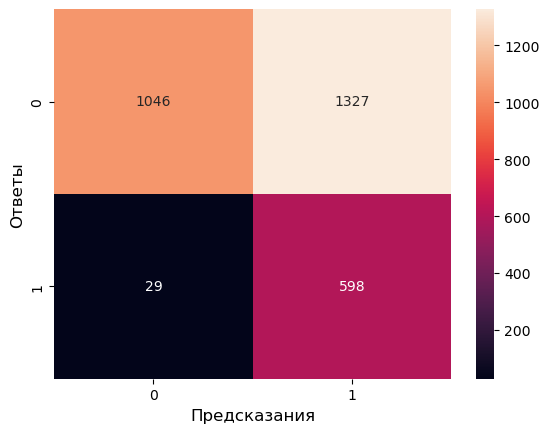

In [59]:
#посмотрим матрицу ошибок 
cf_m = confusion_matrix(y_test, pred)
sns.heatmap(cf_m,annot=True, fmt = 'd')
plt.xlabel('Предсказания', fontsize = 12)
plt.ylabel('Ответы', fontsize = 12)
plt.show()

- После уменьшения выборки модель стала лучше видеть TP, но увеличилось кол-во ложно-положительных, снизилась доля истинно отрицательных, F1 - 0.46, возможно из-за предыдущих настроек модели

In [60]:
#считаем вероятности классов
prob_val = model.predict_proba(X_test)

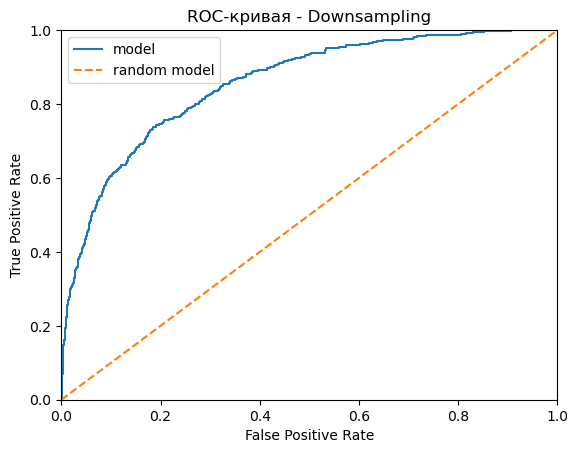

In [61]:
#построим график roc
fpr, tpr, thresholds = roc_curve(y_test, prob_val[:, 1])

plt.figure()
plt.plot(fpr, tpr, label='model')
plt.legend()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--', label='random model')
plt.legend()

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая - Downsampling')
plt.show()

In [62]:
# посчитаем площадь под кривой
auc_roc = roc_auc_score(y_test, prob_val[:, 1])
print('AUC-ROC: ', auc_roc)

AUC-ROC:  0.855557370229005


- Так же относительно предыдущей площадь снизилась, незначительно на 0.01

### GridSearchCV - downsampling

In [63]:
#создадим модель
rfc = RandomForestClassifier(random_state=1)
#создаём словарь в котором будут содержаться условия которые будут тестироваться с помощью GridSearch
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1, 7),
              'min_samples_leaf': range (1,5),
              'min_samples_split': range (2,10,2)}

In [64]:
%%time
#поиск лучших гиперпараметров для модели
grid = GridSearchCV(rfc, parametrs, cv=5,verbose = 5, n_jobs=-1)
grid.fit(X_downsampled, y_downsampled)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Wall time: 2min 17s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': range(1, 7),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)},
             verbose=5)

In [65]:
#лучшие параметры
grid.best_params_

{'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 30}

In [66]:
#сделаем предсказание и посчитаем f1
rfc = grid.best_estimator_
pred = rfc.predict(X_test)
f1 = f1_score(y_test, pred)
print('F1: ',f1)

F1:  0.4618350038550501


- Результат идентичный предыдущему

### Масштабирование признаков

In [67]:
#признаки для масштабирования, среднее будет = 0, std = 1
numeric = ['credit_score', 'age', 'tenure', 'num_of_products', 'estimated_salary','balance']

scaler = StandardScaler()
scaler.fit(X_train[numeric])
#масштабируем обучающую и тестовую
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

X_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
2228,-0.060429,-0.185279,1.082634,-1.226424,0.798528,1,0,-1.376867,0,0,0
5910,-1.743631,0.005323,0.357612,-1.226424,-0.915051,1,1,-1.312339,0,0,0
1950,0.311322,-0.185279,1.807656,0.761149,-0.915051,1,0,-0.318843,0,0,0
2119,0.414586,-0.947689,-0.004898,-1.226424,0.798528,1,0,0.147481,0,0,1
5947,0.063488,0.577131,0.720123,1.116374,-0.915051,1,1,1.727595,0,0,0


### Логистическая регрессия

In [68]:
#потестируем Логистическую регрессию так как классы не равны укажим class_weight='balanced', больший вес будет 
#у редкого класса
model = LogisticRegression(random_state=1, solver='liblinear',class_weight='balanced')
model.fit(X_train, y_train)
predicted_valid = model.predict(X_test)
print('F1:', f1_score(y_test, predicted_valid))

F1: 0.5062537224538415


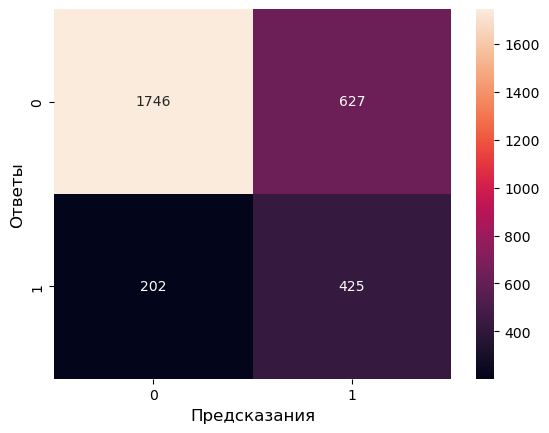

In [69]:
#посмотрим матрицу ошибок 
cf_m = confusion_matrix(y_test, predicted_valid)
sns.heatmap(cf_m,annot=True, fmt = 'd')
plt.xlabel('Предсказания', fontsize = 12)
plt.ylabel('Ответы', fontsize = 12)
plt.show()

- Модель, видит больше истинно отрицательных ответов

### Случайный лес на стандартизированных данных

In [70]:
#создадим модель
rfc = RandomForestClassifier(random_state=1)
#создаём словарь в котором будут содержаться условия которые будут тестироваться с помощью GridSearch
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1, 7),
              'min_samples_leaf': range (1,5),
              'min_samples_split': range (2,10,2)}

In [71]:
%%time
#поиск лучших гиперпараметров для модели
grid = GridSearchCV(rfc, parametrs, cv=5,verbose = 5, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Wall time: 3min 50s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': range(1, 7),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)},
             verbose=5)

In [72]:
#лучшие параметры
grid.best_params_

{'max_depth': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 40}

In [73]:
#сделаем предсказание и посчитаем f1
rfc = grid.best_estimator_
pred = rfc.predict(X_test)
f1 = f1_score(y_test, pred)
print('F1: ',f1)

F1:  0.5305676855895196


### Масштабирование  upsampling данных

In [74]:
# признаки для масштабирования, среднее будет = 0, std = 1
numeric = ['credit_score', 'age', 'tenure', 'num_of_products', 'estimated_salary','balance']

scaler = StandardScaler()
scaler.fit(X_upsampled[numeric])
#масштабируем обучающую 
X_upsampled[numeric] = scaler.transform(X_upsampled[numeric])

X_upsampled.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
6801,-0.114796,0.181416,1.075788,-1.343999,-0.761294,1,0,-1.531083,0,1,1
6707,-0.420963,-0.197617,1.075788,0.374429,-0.761294,1,0,0.076380,1,0,0
1469,1.742613,0.749966,-1.439813,0.628728,3.668412,0,0,1.143386,1,0,0
9215,-0.655690,-0.387134,1.794531,0.849695,3.668412,1,1,-0.510489,1,0,0
7676,-1.951795,-0.766167,0.716416,0.746131,-0.761294,0,1,-0.700019,0,0,0


#### RandomForestClassifier +  масштабирование upsampled данных

In [75]:
#создадим модель
rfc = RandomForestClassifier(max_depth=11,
                             min_samples_leaf=1,
                             min_samples_split=2,
                             n_estimators=40,
                             random_state=1,)

In [76]:
#сделаем предсказание и посчитаем f1
rfc.fit(X_upsampled,y_upsampled)
pred = rfc.predict(X_test)
f1 = f1_score(y_test, pred)
print('F1: ',f1)

F1:  0.5997267759562842


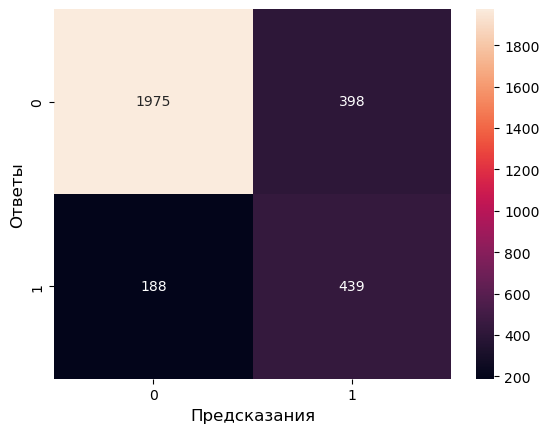

In [77]:
#посмотрим матрицу ошибок 
cf_m = confusion_matrix(y_test, pred)
sns.heatmap(cf_m,annot=True, fmt = 'd')
plt.xlabel('Предсказания', fontsize = 12)
plt.ylabel('Ответы', fontsize = 12)
plt.show()

In [78]:
y_upsampled.value_counts()

1    5640
0    5590
Name: exited, dtype: int64

- По сравнению с предыдущей моделью, можно сказать что улучшили F1, но модель всё ещё видит преимущественно отрицательный класс

#### Логистическая регрессия + масштабирование upsampled данных

In [79]:
#потестируем Логистическую регрессию  
model = LogisticRegression(random_state=1, solver='liblinear')
model.fit(X_upsampled, y_upsampled)
predicted_valid = model.predict(X_test)
print('F1:', f1_score(y_test, predicted_valid))

F1: 0.49413020277481323


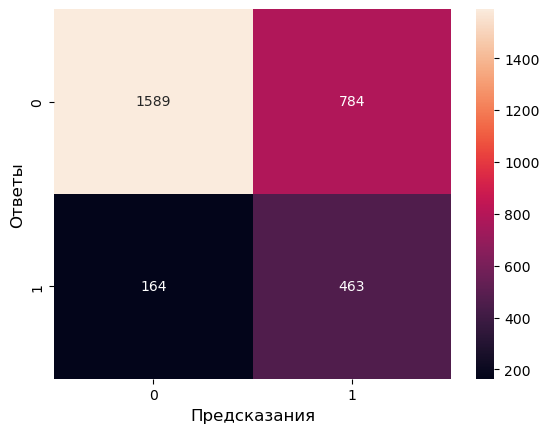

In [80]:
#посмотрим матрицу ошибок 
cf_m = confusion_matrix(y_test,predicted_valid)
sns.heatmap(cf_m,annot=True, fmt = 'd')
plt.xlabel('Предсказания', fontsize = 12)
plt.ylabel('Ответы', fontsize = 12)
plt.show()

- К сожелению Логистическая регрессия видит больше ложно положительных ответов, поэтому F1 менее 0.50

#### Проверка на адекватность

In [81]:
y_train.value_counts()

0    5590
1    1410
Name: exited, dtype: int64

In [82]:
y_upsampled.value_counts()

1    5640
0    5590
Name: exited, dtype: int64

In [83]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(random_state=1)
dummy_clf.fit(X_upsampled, y_upsampled)
DummyClassifier(strategy='most_frequent')
predict = dummy_clf.predict(X_test) 
print('F1:', f1_score(y_test, predict))

F1: 0.3457402812241522


# Общий вывод
<a id='finish'></a>

- Изучили датасет: 
  - привели названия столбцов к хорошему стилю, 
  - удалили два признака, которые на мой взгляд осложнили бы работу модели(RowNumber, CustomerId), 
  - дубликатов не обнаружили
  - пропуски в столбце tenure(кол-во лет клиент является клиентом банка заменили на среднее значение
***
- Разделили данные в отношении 70:30(тестовая)
- Узнали, что для случайного леса на первых трех местах следующие признаки:
   - 1.Возраст
   - 2.Кол-во продуктов банка,которые использует клиентом
   - 3.Активность клиента 
- **Ход исследования:**
   - На несбалансированных данных случайный лес выдал рез-т метрики F1- 0.50
   - После увеличения выборки и подбора гипермараметров результат метрики F1 модели случайный лес- 0.62 [Лучшая модель](#start)
   - Площадь под кривой(AUC-ROC)- 0.86, при максимальном значении 1.
   - На уменьшененной выборке рез-т F1- 0.46
***
- На масштабированной выборке случайный лес показал рез-т F1- 0.53, 
  - можно сказать что метрика немного улучшилась, после масштабирования относительно обычных данных
- На масштабированной выборке и увеличенной случайный лес показал рез-т F1- 0.59
***
- Логистическая регрессия: на масштабируемых данных получили оценку F1- 0.50
  - На масштабированной выборке и увеличенной логистическая регрессия показала рез-т F1- 0.49, после увеличения метрика снизилась
- Так же, проверили нашу модель на адекватность сравнив со случайной,оценка случайной модели F1- 0.34, в то время как F1 нашей модели составляет 0.62 , это значит что наша модель не предсказывает случайным образом и она адекватна

**На мой взгляд, самым лучшим методом борьбы с дисбалансом в данной истории оказалось увеличение выборки**

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*